# Calculation of the Neutrino Flux from Dark Matter annihilation in NGC 1068 with the extragalactic contribution (ref. Carlos Paper, eq. 6)

\begin{equation}
\frac{d\Phi}{dE}=\frac{1}{4\pi}\frac{\Omega_{DM}^2\rho_c^2\left<\sigma v\right>}{\kappa m_\chi^2}\frac{1}{3}\int_0^{z_{up}}dz \frac{(1+G(z))(1+z)^3}{H(z)}\frac{dN(E')}{dE'}
\end{equation}

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad
#from sympy.solvers import solve
#from sympy import Symbol
from scipy.interpolate import UnivariateSpline

## Parameters for the calculation

In [31]:
H_0=70/3.086e19                          #Huble Constant in km/s/Mpc (68*1000 m/s /3,086e+22 m?)
G=6.67259*10**(-11)                      #gravitational constant in Nm^2/kg^2

delta=200


Omega_m0= 0.25                           #fraction of critical density made up of matter
Omega_l0= 0.73                           #fraction of critical density made up of dark energy
Omega_r0= 0.01                           #fraction of critical density made up of radiation 
Omega_dm0= 0.25                          #fraction of critical density made up of dark matter

M_sol=1                             #solar mass in kg
M_low=1e-6*M_sol                    #lower mass integration limit done in Halo Boost factor in [kg] to GeV
M_up=1e15*M_sol                     #lower mass integration limit done in Halo Boost factor in [kg] to GeV

m_chi=1000          #Dark Matter mass in GeV
sigmav=5.71e-25     #thermally-averaged self-annihilation cross-section in [cm^3/s]
kappa=4             #Dirac particle 

z_low=0              #lower integration limit 
z_up=1e5             #upper integration limit as high as neutrino decoupling time T~MeV in [GeV]


h=0.67              #plack constant in m^2kg/s

rho_c0= 1.053e-5 * h**2             #critical density of the universe 3*H_0**2/(8*np.pi*G)
rho_m0=0.05*rho_c0                  #density of matter as fraction of critical density in the universe

## Halo mass function
The Halo mass function 
\begin{equation}
\frac{dn(M,z)}{dM}=\frac{\rho_m(z)}{M^2}\cdot \frac{dln \sigma^{-1}}{dln M}f(\sigma,z)
\end{equation}
with 
\begin{equation}
\rho_m(z)=\rho_{m,0}\cdot(1+z)^3
\end{equation}

The rmx density fluctuation is defined as
\begin{equation}
\sigma^2(z,M)=\left(\frac{D(z)}{D(0)}\right)^2\cdot \int \frac{dk}{k}\frac{k^3P(k)}{2\pi^2}|W(kR)|^2
\end{equation}
so for $\sigma$ results:
\begin{equation}
\sigma(z,M)=\sqrt{\left(\frac{D(z)}{D(0)}\right)^2\cdot \left(exp\left(0.2506 \cdot \left(\frac{M}{M_{sol}}\right)^{0.07536}-2.6\cdot \left(\frac{M}{M_{sol}}\right)^{0.001745}\right)\right)^{-1}}
\end{equation}

with the approximation for the growth factor
\begin{equation}
D(z)=\left(\frac{\frac{5}{2}\Omega_m(z)}{\Omega_m(z)^{4/7}-\Omega_\Lambda(z)+\left(1+\frac{\Omega_m(z)}{2}\right)\cdot\left(1+\frac{\Omega_\Lambda}{70}\right)}\right)\frac{1}{1+z}
\end{equation}

with 
\begin{equation}
\Omega_m(z)=\Omega_{m,0}\frac{(1+z)^3}{\Omega_{m,0}(1+z)^3+\Omega_{\Lambda,0}}
\end{equation}

and
\begin{equation}
\Omega_\Lambda(z)=1-\Omega_{m}(z)
\end{equation}


In [32]:
def Omega_m(z):
    return Omega_m0*(1+z)**3/(Omega_m0*(1+z)**3+Omega_l0)

def Dlopez(z):
    return 1/(1+z)*((2.5*Omega_m(z))/(Omega_m(z)**(4/7)-(1-Omega_m(z))+(1+Omega_m(z)/2)*(1+(1-Omega_m(z))/70)))

D0=Dlopez(0)

def sigmalopez(z,M):
    return (np.exp(0.2506*(M)**0.07536-2.6*(M)**0.0001745))**(-1)*(Dlopez(z)/D0)


def dlnsigmalopez(M):
    return (0.2506*0.07536*M**(0.07536-1)-2.6*0.001745*M**(0.001745-1))#*M

def lnsigmalopez(M):
    return 0.2506*M**(0.07536)-2.6*M**(0.001745)


In [33]:
#sigma and D(z) from prada paper
def a(z):
    return 1/(1+z)

def x(z):
    return (Omega_l0/Omega_m0)**(1/3)*a(z)


def Dprada(z):
    x_values=(Omega_l0/Omega_m0)**(1/3) * a(z)
    D_result=[]
    if isinstance(x_values,float):
        x=x_values
        prefactor = np.sqrt(1+x**3)/x**(3/2)
        D= lambda x: x**(3/2)/(1+x**3)**(3/2)
        x_int = integrate.quad(D,0, x)
        result = (5/2)*(Omega_l0/Omega_m0)**(1/3)*prefactor* x_int[0]
        D_result.append(result)
    elif len(x_values)>= 1:
        for x in x_values:
            prefactor = np.sqrt(1+x**3)/x**(3/2)
            D= lambda x: x**(3/2)/(1+x**3)**(3/2)
            x_int = integrate.quad(D,0, x)
            result = (5/2)*(Omega_l0/Omega_m0)**(1/3)*prefactor* x_int[0]
            D_result.append(result)
    else:
        print('error!')
    return np.array(D_result)


def y(M):
    return (M*h/1e12)**(-1)


def sigmaprada(z,M):
    return 16.9*(y(M)**0.41)/(1+1.102*(y(M)**0.20)+6.22*(y(M)**0.333))*Dprada(z)

def lnsigmaprada(M):
    return np.log((sigmaprada(0,M))**(-1))


def dy(M):
    return -1*1e12/h*1/(M**2)

def dlnsigmady(M):
    return (-1)*(16.9*y(M)**0.41/(1+1.102*y(M)**0.20+6.22*y(M)**0.333))**(-1)*(16.9*0.41*y(M)**(0.41-1)*(1+1.102*y(M)**0.20+6.22*y(M)**0.333)-16.9*y(M)**0.41*(1.102*0.20*y(M)**(0.20-1)+6.22*0.333*y(M)**(0.333-1)))*1/((1+1.102*y(M)**0.20+6.22*y(M)**0.333)**2)
    

def dlnsigmaprada(M):
    return dy(M)*dlnsigmady(M)


def dlnwolphram(M):
    return -1*(23947*y(M)**(9/5)+11571*y(M)**(1667/1000)+20500*y(M)**(1467/1000))/(311000*y(M)**(14/5)+55100*y(M)**(2667/1000)+50000*y(M)**(2467/1000))*dy(M)

def dln_inv_dlogM_prada(M): # change the results --- 
    y = (M * h / (1e12 ))**(-1)
    dln_sigma_inv_dy = -(0.0372058*(y**1.997+10.9392*y**1.8+1.77167*y**1.797))/((y**0.003+0.17717*y**0.2+0.160772)*y**2.797)
    dy_dm = -y/M
    dln_sigma_inv_dm = dln_sigma_inv_dy * dy_dm
    return dln_sigma_inv_dm



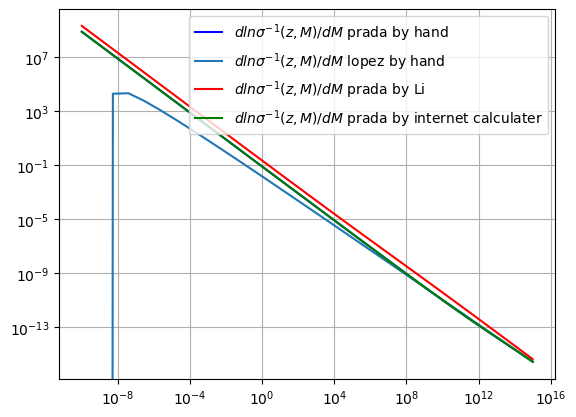

In [34]:
#Test plot for calculation of dlnsigma-1/dlnM
mass=np.logspace(-10, 15, 30)
plt.plot(mass,dlnsigmaprada(mass),'b-',label="$dln\sigma^{-1}(z,M)/dM$ prada by hand")
plt.plot(mass,dlnsigmalopez(mass),'-',label="$dln\sigma^{-1}(z,M)/dM$ lopez by hand")
plt.plot(mass,dln_inv_dlogM_prada(mass),'r-',label="$dln\sigma^{-1}(z,M)/dM$ prada by Li")
plt.plot(mass,dlnwolphram(mass),'g-',label="$dln\sigma^{-1}(z,M)/dM$ prada by internet calculater")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()

#by hand and internet calculater perfect but Lis solution a little different 

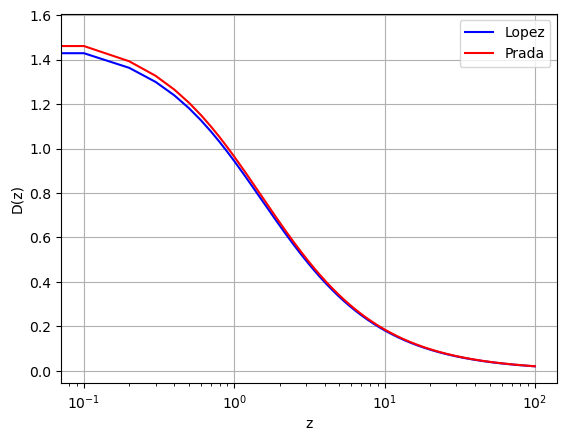

In [35]:
#Test plot D(z)
z_gridD=np.arange(0,100,0.1)
plt.plot(z_gridD,Dlopez(z_gridD)*2,'b-',label="Lopez")
plt.plot(z_gridD,Dprada(z_gridD),'r-',label="Prada")
plt.grid(True)
plt.xscale('log')
plt.xlabel('z')
plt.ylabel('D(z)')
plt.legend()

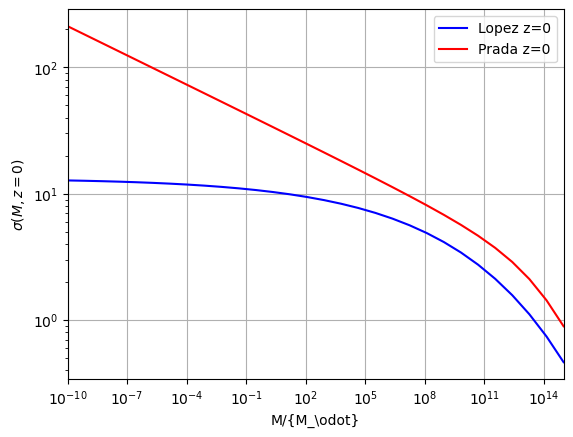

In [36]:
#Test plot sigma and M
mass=np.logspace(-10, 15, 30)
plt.plot(mass,sigmalopez(0,mass),'b-',label="Lopez z=0")
plt.plot(mass,sigmaprada(0,mass),'r-',label="Prada z=0")
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M/{M_\odot}')
plt.ylabel('$\sigma(M,z=0)$')
plt.xlim([1e-10,1e15])
plt.legend()

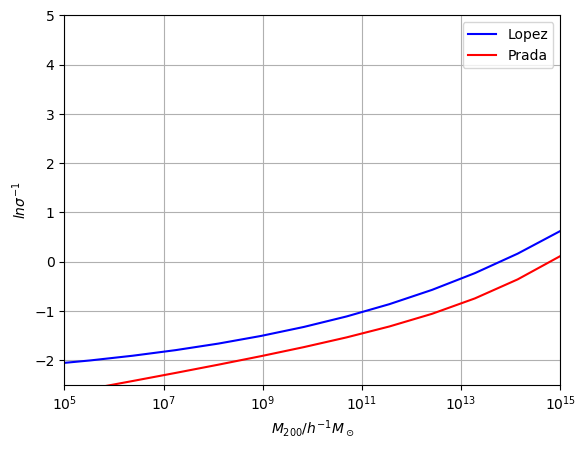

In [37]:
#test ln sigma and M
plt.plot(mass,lnsigmalopez(mass),'b-',label='Lopez')
plt.plot(mass,lnsigmaprada(mass),'r-',label='Prada')
plt.xlabel(r'$M_{200}/h^{-1} M_\odot$')
plt.ylabel(r'$ln \sigma^{-1}$')
plt.xscale('log')
plt.grid(True)
plt.xlim([1e5,1e15])
plt.ylim([-2.5,5])
plt.legend()

Universial function with respect to redshift for different overdensities $\Delta$
\begin{equation}
f_\Delta(z,\sigma)=\left(e^{\left(\frac{\Delta}{178}-1\right)\cdot\left(0.023-\frac{0.072}{\sigma^{2.13}}\right)}\cdot \left(\frac{\Delta}{178}\right)^{-0.456\Omega_m(z)-0.139}\right)\cdot f_{178}(z,\sigma)
\end{equation}

with the $f_{178}(z,\sigma)$ being:
\begin{equation}
f_{178}(z,\sigma)=A(z)\left(\left(\frac{\sigma}{\beta (z)}\right)^{-\alpha (z)}+1\right)\cdot e^{\frac{-\gamma}{\sigma^2}}
\end{equation}

with
\begin{equation}
A_{178}(z)=\Omega_m(z)\left(1.097(1 + z)^{-3.216}+0.074\right)
\end{equation}
\begin{equation}
\alpha_{178}(z)=\Omega_m(z)\left(5.907(1 + z)^{-3.599}+2.344\right)
\end{equation}
\begin{equation}
\beta_{178}(z)=\Omega_m(z)\left(3.136(1 + z)^{-3.068}+2.349\right)
\end{equation}
\begin{equation}
\gamma_{178}=1.318
\end{equation}

In [38]:
def A(z):
    return Omega_m(z)*(1.097*(1+z)**(-3.216)+0.074)

def alpha(z):
    return Omega_m(z)*(5.907*(1+z)**(-3.599)+2.344)

def beta(z):
    return Omega_m(z)*(3.136*(1+z)**(-3.068)+2.349)

gamma178 = 1.318
def f178lopez(z,M):
    return A(z)*((sigmalopez(z,M)/beta(z))**(-alpha(z))+1)*np.exp(-gamma178/(sigmalopez(z,M)**2))

def f200lopez(z,M):
    return (np.exp((delta/178-1)*(0.023-0.072/(sigmalopez(z,M)**2.13)))*(delta/178)**(-0.456*Omega_m(z)-0.139))*f178lopez(z,M)


def f178prada(z,M):
    return A(z)*((sigmaprada(z,M)/beta(z))**(-alpha(z))+1)*np.exp(-gamma178/(sigmaprada(z,M)**2))

def f200prada(z,M):
    return (np.exp((delta/178-1)*(0.023-0.072/(sigmaprada(z,M)**2.13)))*(delta/178)**(-0.456*Omega_m(z)-0.139))*f178prada(z,M)

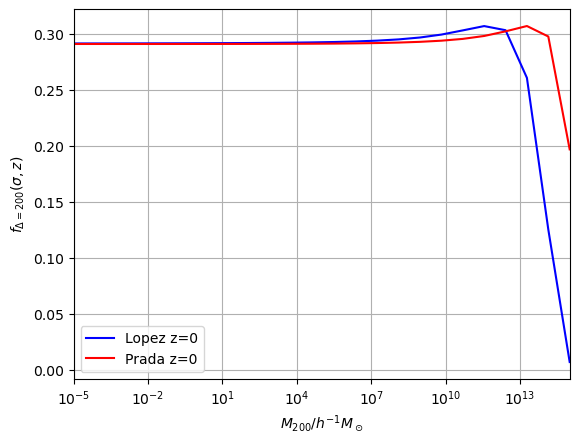

In [39]:
#Test plot f200(z,M)
z_gridF=np.linspace(0,0,30)
plt.plot(mass,f200lopez(z_gridF,mass),'b-',label='Lopez z=0')
plt.plot(mass,f200prada(z_gridF,mass),'r-',label='Prada z=0')

plt.xlabel(r'$M_{200}/h^{-1} M_\odot$')
plt.ylabel(r'$f_{\Delta=200}(\sigma,z)$')
plt.grid(True)
plt.xscale('log')
plt.xlim([1e-5,1e15])
plt.legend()

In [40]:
def HMFlopez(z,M):
    return rho_m0*(1+z)**3/(M**2)*dlnsigmalopez(M)*M*f200lopez(z,M)

def HMFprada(z,M):
    return rho_m0*(1+z)**3/(M**2)*dlnsigmaprada(M)*M*f200prada(z,M)


## Halo Boost factor

\begin{equation}
G(z)=\frac{1}{\Omega_{DM,0}^2\rho_{c,0}^2}\frac{1}{(1+z)^6}\int dM \frac{dn(M,z)}{dM}\int dr 4\pi r^2\rho_\chi^2(r)
\end{equation}

with the NFW halo density profile 
\begin{equation}
\rho_\chi(r)=\rho_s\cdot \frac{2^{3-\gamma}}{\left(\frac{r}{r_s}\right)^\gamma\left(1+\frac{r}{r_s}\right)^{3-\gamma}}
\end{equation}

Calculating the Halo Boost Factor without the integrationover the mass M. This step is included in the calculation of the flux (integrating over z and M at once). 


Approximation for the integral over the density profile given by
\begin{equation}
\int dr 4\pi r^2\rho_\chi^2(r)=g(c_\Delta)\frac{M \Delta \rho_c(z)}{3}
\end{equation}


with 
\begin{equation}
g(c_\Delta)=\frac{c_{\Delta}^3(1-(1+c_{\Delta})^{-3})}{3(ln(1+c_{\Delta})-c_{\Delta}(1+c_{\Delta})^{-1})^2}
\end{equation}


for an overdensity of 200 it results:
\begin{equation}
c_{200}(M,z)=B_0(x)C(\sigma')
\end{equation}
with
\begin{equation}
C(\sigma')=A\left(\left(\frac{\sigma'}{b}\right)^c+1\right)exp\left(\frac{d}{\sigma'^2}\right)
\end{equation}
\begin{equation}
\sigma'=B_1(x)\sigma(M,x)
\end{equation}
\begin{equation}
x(z)=\left(\frac{\Omega_{\Lambda ,0}}{\Omega_{m,0}}\right)^{\frac{1}{3}}\frac{1}{1+z}
\end{equation}

\begin{equation}
B_0(x)=\frac{c_{min}(x)}{c_{min}(1.393)}
\end{equation}
\begin{equation}
B_1(x)=\frac{\sigma_{min}^{-1}(x)}{\sigma_{min}^{-1}(1.393)}
\end{equation}

\begin{equation}
c_{min}(x)=c_0+(c_1-c_0)\left(\frac{1}{\pi}arctan(\alpha(x-x_0))+\frac{1}{2}\right)
\end{equation}
\begin{equation}
\sigma_{min}^{-1}(x)=\sigma_0^{-1}+(\sigma_1^{-1}-\sigma_0^{-1})\left(\frac{1}{\pi}arctan(\beta(x-x_1))+\frac{1}{2}\right)
\end{equation}

In [41]:
def rho_c(z):
    return rho_c0*(Omega_m0*(1+z)**3+Omega_l0)

def sigm_min(z):
    return 1.047+(1.646-1.047)*(1/np.pi*np.arctan(7.386*(x(z)-0.526))+0.5)

def B_1(z):
    return sigm_min(z)/sigm_min(1.393)

def sigma_strichlopez(z,M):
    return B_1(z)*sigmalopez(x(z),M)

def sigma_strichprada(z,M):
    return B_1(z)*sigmaprada(x(z),M)

def Clopez(z,M):
    return 2.881*((sigma_strichlopez(z,M)/1.257)**1.022+1)*np.exp(0.060/(sigma_strichlopez(z,M)**2))

def Cprada(z,M):
    return 2.881*((sigma_strichprada(z,M)/1.257)**1.022+1)*np.exp(0.060/(sigma_strichprada(z,M)**2))

def c_min(z):
    return 3.681+(5.033-3.681)*(1/np.pi*np.arctan(6.948*(x(z)-0.424))+0.5)

def B_0(z):
    return c_min(z)/c_min(1.393)

def c_200lopez(z,M):
    return B_0(z)*Clopez(z,M)

def c_200prada(z,M):
    return B_0(z)*Cprada(z,M)

def glopez(z,M):
    return c_200lopez(z,M)**3*(1-(1+c_200lopez(z,M))**(-3))/(3*(np.log(1+c_200lopez(z,M))-c_200lopez(z,M)*(1+c_200lopez(z,M))**(-1))**2)

def gprada(z,M):
    return c_200prada(z,M)**3*(1-(1+c_200prada(z,M))**(-3))/(3*(np.log(1+c_200prada(z,M))-c_200prada(z,M)*(1+c_200prada(z,M))**(-1))**2)



/tmp/ipykernel_3981/1564218205.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,1e4])


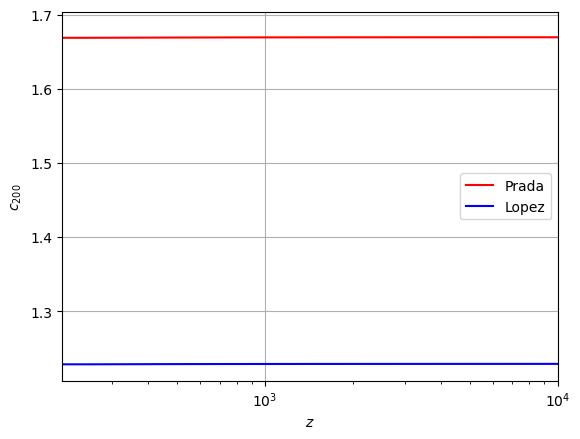

In [42]:
#Test plot c200 and z
massC=np.logspace(-10, 16, 42)
z_gridC=np.linspace(0,1e4,42)

fixed_mass = np.full((42,),12)

plt.plot(z_gridC,np.log10(c_200prada(z_gridC,fixed_mass)),'r-',label='Prada')
plt.plot(z_gridC,np.log10(c_200lopez(z_gridC,fixed_mass)),'b-',label='Lopez')
plt.grid(True)
plt.xlabel(r'$z$')
plt.xscale('log')
plt.ylabel(r'$c_{200}$')
plt.xlim([0,1e4])
plt.legend()

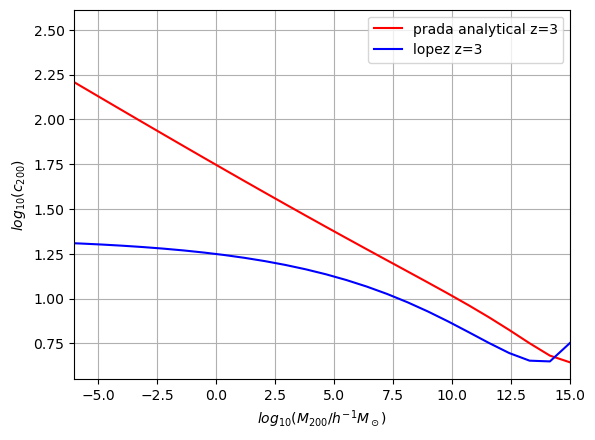

In [43]:
#Test plot logc200 und logM for z=3
z_3_grid=np.linspace(3,3,30)
plt.plot(np.log10(mass),np.log10(c_200prada(z_3_grid,mass)),'r-',label='prada analytical z=3')
plt.plot(np.log10(mass),np.log10(c_200lopez(z_3_grid,mass)),'b-',label='lopez z=3')
plt.xlabel(r'$log_{10} (M_{200}/h^{-1} M_\odot)$')
plt.ylabel(r'$log_{10}(c_{200})$')
plt.xlim([-6,15])
plt.grid(True)
#plt.ylim([0.5,1.2])
plt.legend()

(4.0, 10.0)

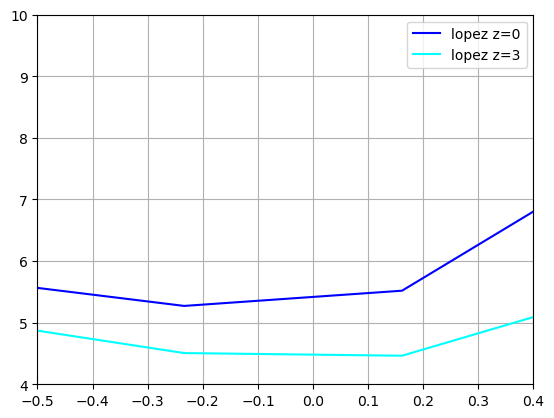

In [44]:
#Test plot log sigma-1 and c
plt.plot(lnsigmalopez(mass),c_200lopez(0,mass),'b-',label="lopez z=0")
plt.plot(lnsigmalopez(mass),c_200lopez(3,mass),'-',color="cyan",label="lopez z=3")
plt.legend()
plt.grid(True)
plt.xlim([-0.5,0.4])
plt.ylim([4,10])

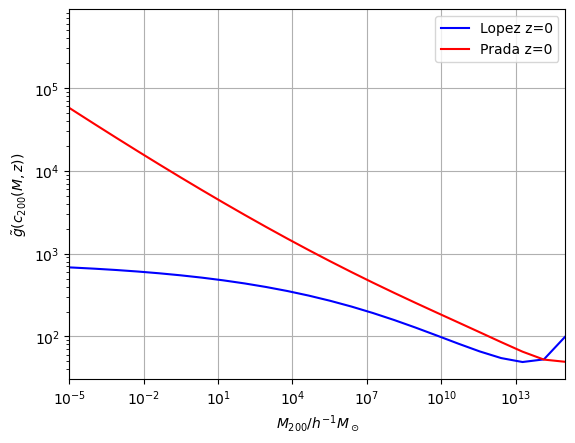

In [45]:
#Test plot gtilde und logM
z_0_grid=np.linspace(0,0,30)
plt.plot(mass,glopez(z_0_grid,mass),'b-',label='Lopez z=0')
plt.plot(mass,gprada(z_0_grid,mass),'r-',label='Prada z=0')

plt.xlabel(r'$ M_{200}/h^{-1} M_\odot$')
plt.ylabel(r'$\tilde{g}(c_{200}(M,z))$')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.xlim([1e-5,1e15])
plt.legend()

### G-factor (formular from Lopez paper)
\begin{equation}
G(z)=\left(\frac{\Omega_{m0}}{\Omega_{DM0}}\right)^2\frac{\Delta}{3\Omega_m(z)}\cdot \int_{M_{min}}^{\infty} dlogM\frac{d ln\sigma^{-1}(z,M)}{d log M}\cdot f_{\Delta}(\sigma(z,M),z)\cdot\tilde{g}(c_{\Delta}(z,M))
\end{equation}

In [46]:
#def NFW_int1(z,M):
#    return g(z,M)*M*delta*rho_c(z)/3

#def NFW_int2(z):
#    return g(z,1)*1*delta*rho_c(z)/3


#def HMF_int(z):
#    return integrate.quad(lambda M: HMF(z,M), M_low, M_up)

#def G(z):
#    return 1/(Omega_dm0**2*rho_c0**2)*1/((1+z)**6)*HMF_int(z)[0]*NFW_int2(z)

M=np.logspace(-9, 15, 42)

z=np.linspace(0,200,42)


MGfactor=np.logspace(-5, 16, 42)



def Glopez(z):
    def integrandlopez(M):
        return dlnsigmalopez(M)*f200lopez(z,M)*glopez(z,M)
    binslopez=np.array([integrandlopez(M) for M in MGfactor])
    int_valueslopez = np.trapz(binslopez, x=MGfactor,axis=0)
    return ((Omega_m0/Omega_dm0)**2) * (delta/(3*Omega_m0/a(z)**3))*int_valueslopez

def Gprada(z):
    def integrandprada(M):
        return dlnsigmaprada(M)*f200prada(z,M)*gprada(z,M)
    binsprada=np.array([integrandprada(M) for M in MGfactor])
    int_valuesprada = np.trapz(binsprada, x=MGfactor,axis=0)
    return ((Omega_m0/Omega_dm0)**2) * (delta/(3*Omega_m0/a(z)**3))*int_valuesprada

#refernce plot
import csv

with open('../data/mydataGref.csv', 'r') as csv_datei:
    reader = csv.reader(csv_datei, delimiter=';')
    xdataGref=[]
    ydataGref=[]
    for row in reader:
        xdataGref.append(row[0])
        ydataGref.append(row[1])
        #print(xdataGref)
        #print(ydataGref)
    
xdataG=np.asarray(xdataGref)
ydataG=np.asarray(ydataGref)
xdatarefG = xdataG.astype(float)
ydatarefG = ydataG.astype(float)


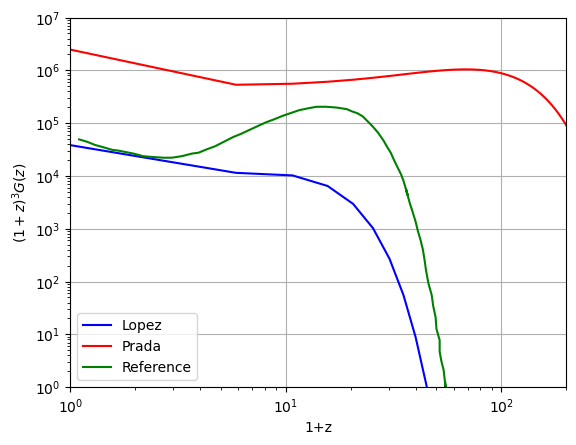

In [47]:
plt.plot((1+z),Glopez(z)*(1+z)**3,'b-',label='Lopez')
plt.plot((1+z),Gprada(z)*(1+z)**3,'r-',label='Prada')
plt.plot(xdatarefG,ydatarefG,'g',label='Reference')
plt.legend()
plt.xlabel('1+z')
plt.ylabel(r'$(1+z)^3 G(z)$')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1, 200])
plt.ylim([1e0,1e7])
plt.grid(True)
plt.legend()

## Neutrino Energy Spectrum of DM annihilation

Spectrum related to the source production spectrum via a Jacobian transformation to take cosmological
redshift into account

\begin{equation}
\frac{dN}{dE}=\frac{2}{E}\delta\left(z-\left(\frac{m_\chi}{E}-1\right)\right)
\end{equation}

peak of height $\frac{2}{E}$ if $z-\left(\frac{m_\chi}{E}-1\right)$ is equal 0

Text(0, 0.5, 'dN/dE in 1/GeV')

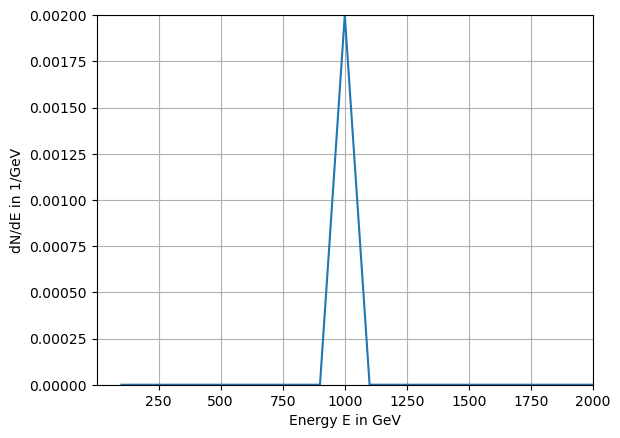

In [48]:
def dNdE(z,E):
    if z-(m_chi/E-1)==0:
        res=2/E
    else:
        res=0
    return res  

EdN=np.linspace(100,5000)
plt.plot(EdN,[dNdE(0,i) for i in EdN],'-')
plt.xlim([1,2000])
plt.ylim([0,0.002])
#plt.yscale('log')
plt.grid(True)
plt.xlabel("Energy E in GeV")
plt.ylabel("dN/dE in 1/GeV")

## Calculation of the Flux 

Inserting the Halo Boost Factor calculated before and the time-dependet Hubble parameter

\begin{equation}
H(z)=H_0\cdot\left((1+z)^3\Omega_m+(1+z)^4\Omega_r+\Omega_\Lambda\right)
\end{equation}

in eq. 6 of Carlos 
\begin{equation}
\frac{d\Phi}{dE}=\frac{1}{4\pi}\frac{\Omega_{DM}^2\rho_c^2\left<\sigma v\right>}{\kappa m_\chi^2}\frac{1}{3}\int_0^{z_{up}}dz \frac{(1+G(z))(1+z)^3}{H(z)}\frac{dN(E')}{dE'}
\end{equation}


Text(0, 0.5, '$\\frac{d\\Phi}{dE}[1/(GeV)]$')

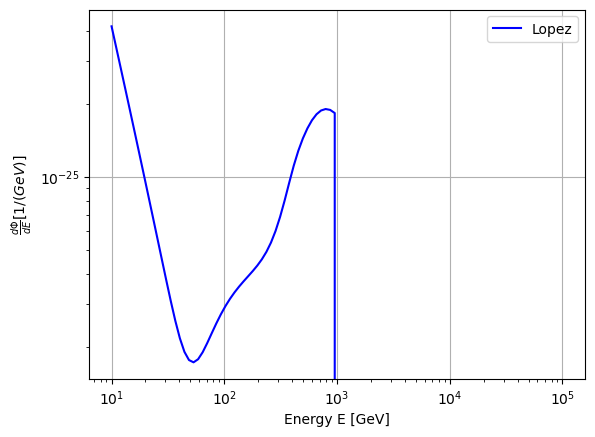

In [49]:
def H(z):
    return H_0*((1+z)**3*Omega_m0+(1+z)**4*Omega_r0+Omega_l0)**0.5

def dPhilopez(E):
    z=m_chi/E-1
    z0=z[z>0]
    res=1/(4*np.pi*3)*(Omega_dm0**2*rho_c0**2*sigmav)/(kappa*m_chi**2)*(1+Glopez(z0))*(1+z0)**3/H(z0)*2/E[E<m_chi]
    result = np.zeros_like(E) 
    result[0:len(res)] = res
    return result

def dPhiprada(E):
    z=m_chi/E-1
    z0=z[z>0]
    res=1/(4*np.pi*3)*(Omega_dm0**2*rho_c0**2*sigmav)/(kappa*m_chi**2)*(1+Gprada(z0))*(1+z0)**3/H(z0)*2/E[E<m_chi]
    result = np.zeros_like(E) 
    result[0:len(res)] = res
    return result



E=np.logspace(1, 5, 100)
plt.plot(E,dPhilopez(E),'b-',label='Lopez')
#plt.plot(E,dPhiprada(E),'r-',label='Prada')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.xlabel(r'Energy E [GeV]')
plt.ylabel(r'$\frac{d\Phi}{dE}[1/(GeV)]$')

#print(np.sum(E*dPhilopez(E)))


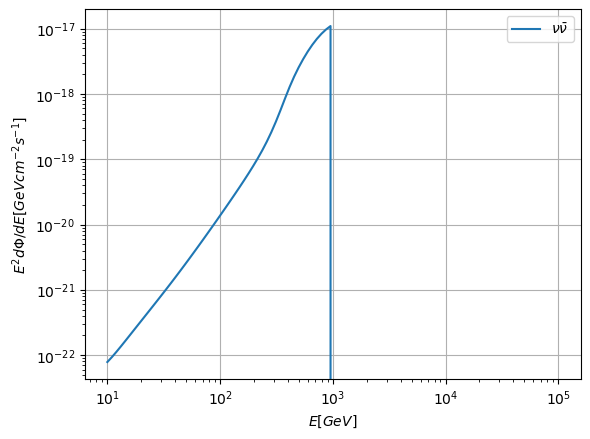

In [50]:
#plot E^2*dPhidE
#plt.plot(E,dPhilopez(E)*E**2,'-', label=r'$\nu\bar{\nu}$')
plt.plot(E,dPhiprada(E)*E**2,'-',label=r'$\nu\bar{\nu}$')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('$E[GeV]$')
plt.ylabel(r'$E^2 d\Phi/dE [GeV cm^{-2} s^{-1}]$')
plt.grid(True)

plt.savefig(r"\Users\Lexi\Documents\Uni\Bachelorthesis\Bilder\extrafluxnunu.pdf")
plt.savefig(r"\Users\Lexi\Documents\Uni\Bachelorthesis\Bilder\extrafluxnunu.png")

Text(0, 0.5, '$dN/dE$')

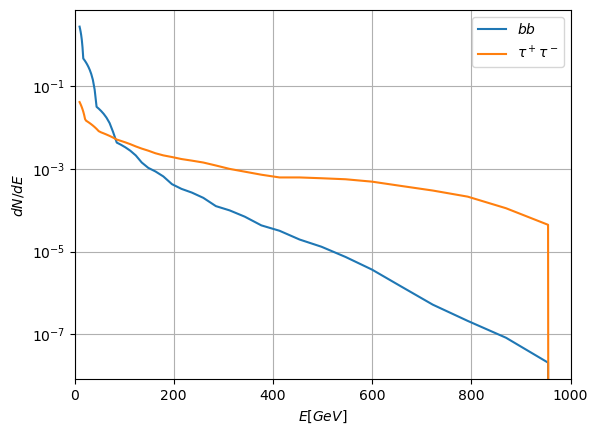

In [51]:
#Calculation of Flux for annihilation channels bb and tau


bb = [6.505511089551874, 3.7673577794680906,
17.184538406949287, 0.4608870123818879,
43.39342981108686, 0.03179099695557441,
82.15700541676776, 0.004417344703140083,
139.70589556328096, 0.0011601553017399739,
200.3952533663909, 0.0003688249366560895,
284.4836104598413, 0.00012496091412919893,
368.5791539781353, 0.0000451209131433661,
460.47915487643854, 0.000017363262715527026,
567.9377655608556, 0.000004859996367971554,
676.8839661878712, 7.196856730011529e-7,
809.2507253797575, 1.3748295177747968e-7,
902.7101804690939, 5.290568041106863e-8,
957.1760943577582, 1.9103194204792716e-8,
982.0051921919495, 6.4723189062577304e-9,
998.9723412473837, 1.236419650215925e-9,
1006.395918110689, 4.51209131433661e-11]

tautau =[4.464566434006201, 0.05290568041106868,
21.474834038501285, 0.014808358247838268,
49.47314522866307, 0.007834462688727404,
85.29028664852095, 0.005017193252114605,
128.9046990235445, 0.003213012701596418,
169.40738944134532, 0.0021928747399631876,
216.16226947296556, 0.0016998662314736362,
259.805427547363, 0.0014043179200924883,
304.99366696310665, 0.0010214487701467323,
354.86745537679326, 0.0007918036720975034,
404.74124379047976, 0.0006137880562106195,
459.3221404766397, 0.0006137880562106195,
513.895850737956, 0.0005759286237751607,
568.4695609992724, 0.0005404044218966212,
679.1405035887208, 0.00034607522259998537,
774.2240906926816, 0.00023619564696696646,
855.2438443779698, 0.00012496091412919893,
923.7735916853063, 0.00005820723351294768,
995.4150609498657, 0.000025440752556199534]

Espec=np.logspace(1, 5, 100)
dNdE_bb = UnivariateSpline(bb[0::2],bb[1::2], k=1, s=0, ext=1)
dNdE_tautau = UnivariateSpline(tautau[0::2],tautau[1::2], k=1, s=0, ext=1)

plt.plot(Espec,dNdE_bb(Espec),label=r'$b b$')
plt.plot(Espec,dNdE_tautau(Espec),label=r'$\tau^+ \tau^-$')

plt.yscale('log')
plt.legend()
plt.grid(True)
plt.xlim([0,1000])
plt.xlabel(r'$E[GeV]$')
plt.ylabel(r'$dN/dE$')

In [52]:
def dPhi_taulopez(E):
    zgrid=np.linspace(0,5,100)
    dNdE = dNdE_tautau(E)
    result = np.trapz(dNdE*Glopez(zgrid)/H(zgrid))
    return result

print(dPhi_taulopez(np.logspace(1,5,100)))

E=np.logspace(1, 5, 100)
#plt.plot(E,dPhi_taulopez(E),'b-',label='Lopez')
#plt.plot(E,dPhiprada(E),'r-',label='Prada')
#plt.xscale('log')
#plt.yscale('log')
#plt.grid(True)
#plt.legend()
#plt.xlabel(r'Energy E [GeV]')
#plt.ylabel(r'$\frac{d\Phi}{dE}[1/(GeV)]$')

#print(np.sum(E*dPhi_taulopez(E)))

2.7499348935605486e+21


## Moline Parametrization

\begin{equation}
\frac{d\Phi(E_0)}{dE_0}=\frac{\sigma v}{2} \frac{\rho_{m,0}^2}{m_\chi^2} \int dz \frac{\zeta^2(z)}{H(z)} \frac{dN(E)}{dE}
\end{equation}

with $E=E_0(1+z)$ and $H(z)=H_0(\Omega_{m,0}(1+z)^3+\Omega_\Lambda)^{\frac{1}{2}}$

\begin{equation}
\zeta^2(z)=\frac{\Delta \rho_c(z)}{\rho_{m,0}} \int dM \frac{M}{\rho_{m,0}} \frac{dn(M,z)}{dM} \zeta_M^2(M,z)
\end{equation}

\begin{equation}
\zeta_M^2(M,z)=\frac{1}{9} \frac{c^3(1-(1+c)^{-3})}{(ln(1+c)-c(1+c)^{-1})^2}
\end{equation}



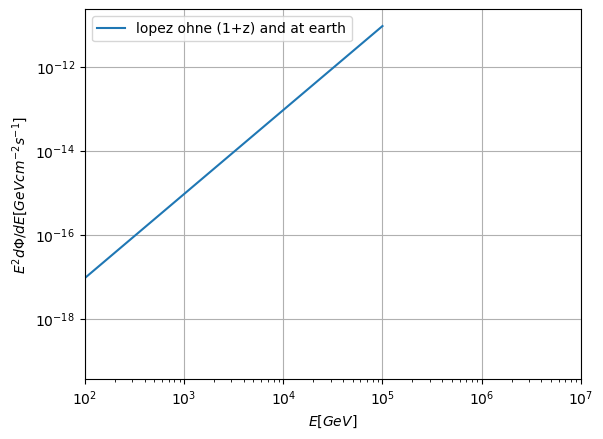

In [53]:
def H_Moline(z):
    return H_0*(Omega_m0*(1+z)**3+Omega_l0)**0.5


def dPhidE_extra_channel(E):
    z_grid=np.linspace(0,5,100)
    E_1= E*(1+z_grid)
    dNdE = dNdE_tautau(E_1)
    boost_int = np.trapz(dNdE*Glopez(z_grid)/H_Moline(z_grid))
    Physics = sigmav * (rho_c0*Omega_m0)**2/m_chi**2/2
    result = Physics*boost_int
    
    return result

E_log_grid=np.logspace(1, 5, 100)

plt.plot(E_log_grid,dPhidE_extra_channel(E_log_grid)*(E_log_grid**2),label='lopez ohne (1+z) and at earth')
plt.xlabel('$E[GeV]$')
plt.ylabel(r'$E^2 d\Phi/dE [GeV cm^{-2} s^{-1}]$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e2,1e7])
#plt.ylim([0, 1e-16])
plt.legend()
plt.grid(True)

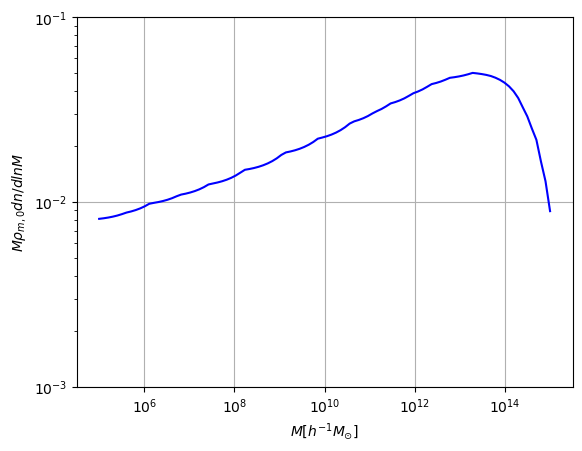

In [59]:
# Halo mass function taken from Moline paper with webplotdigitizer


import csv

with open('../data/DataMoline_dndM.csv', 'r') as csv_datei:
    reader = csv.reader(csv_datei, delimiter=';')
    xdataMoline=[]
    ydataMoline=[]
    for row in reader:
        xdataMoline.append(row[0])
        ydataMoline.append(row[1])
        #print(xdataGref)
        #print(ydataGref)
    
xdataM=np.asarray(xdataMoline)
ydataM=np.asarray(ydataMoline)
xdataref_dndM = xdataM.astype(float)
ydataref_dndM = ydataM.astype(float)

          
#plt.plot(xdataref_dndM,ydataref_dndM/(xdataref_dndM**2*rho_c0),'-',)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M[h^{-1} M_{\odot}]$')
plt.ylabel(r'$M\rho_{m,0} dn/dlnM$')
plt.grid(True)
plt.ylim([1e-3,1e-1])
M_grid=np.logspace(5,15,23)
from scipy.interpolate import interp1d

dndM_new = interp1d(xdataref_dndM, ydataref_dndM,bounds_error=False, fill_value=0)
#plt.plot(xdataref_dndM,dndM_new(xdataref_dndM),'g')

dndM=UnivariateSpline(xdataref_dndM, ydataref_dndM, k=1, s=0, ext=0)

M_grid=np.logspace(5,15,100)
plt.plot(M_grid,dndM(M_grid),'b')

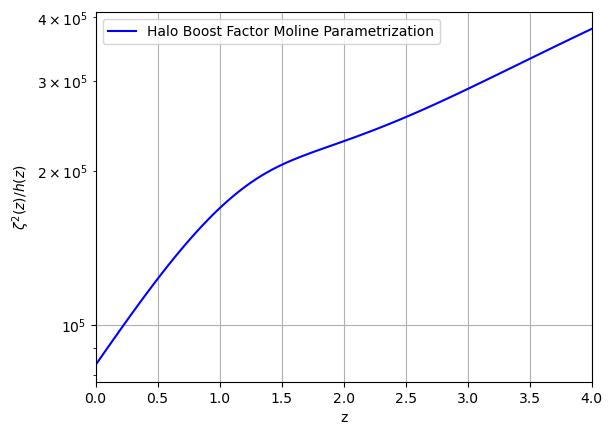

In [60]:
# Halo Boost Factor

def Gmoline(z):
    moline_int_grid=np.logspace(-5, 16, 42)
    def integrand(M):
        return glopez(z,M)/3*dndM_new(M)/M
    to_int_values=np.array([integrand(M) for M in moline_int_grid])
    int_values = np.trapz(to_int_values, x=moline_int_grid,axis=0)
    return 200/(rho_m0)*rho_c(z)*int_values

z=np.linspace(0,4,100)
plt.plot(z,Gmoline(z)/(H_Moline(z)/H_0),'b', label=r'Halo Boost Factor Moline Parametrization')
plt.yscale('log')
plt.grid(True)
plt.xlim([0,4])
plt.xlabel('z')
plt.ylabel(r'$\zeta^2(z)/h(z)$')
plt.legend()

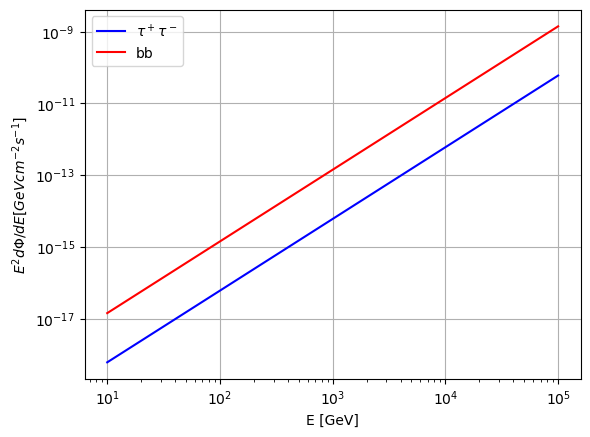

In [61]:
# Flux 


def dPhimolinetau(E):
    z=np.linspace(0,5,100)
    E1= E*(1+z)
    dNdE = dNdE_tautau(E1)
    integral = np.trapz(dNdE*Gmoline(z)/H_Moline(z))
    prefac = sigmav * (rho_c0*Omega_m0)**2/m_chi**2/2
    result = integral*prefac
    return result

def dPhimolineb(E):
    z=np.linspace(0,5,100)
    E1= E*(1+z)
    dNdE = dNdE_bb(E1)
    integral = np.trapz(dNdE*Gmoline(z)/H_Moline(z))
    prefac = sigmav * (rho_c0*Omega_m0)**2/m_chi**2/2
    result = integral*prefac
    return result

E=np.logspace(1, 5, 100)
plt.plot(E,dPhimolinetau(E)*E**2,'b-',label=r'$\tau^+\tau^-$')
plt.plot(E,dPhimolineb(E)*E**2,'r-', label= 'bb')
plt.legend()
plt.xlabel(r'E [GeV]')
plt.ylabel(r'$E^2 d\Phi/dE [GeV cm^{-2} s^{-1}]$')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)

## Problem and Questions

1. Shape of fluxes not correct. May be due to dN/dE because if dN/dE is power spectrum the result would probably look like in plots before and would be similar to Moline paper?
2. For tau channel flux should be higher as for bb channel but here it is the otehr way around

In [62]:
def dphide_channel(E,m_x,channel_function=dNdE_tautau):
    # What is the z for T = 1 MeV
    z = m_x / E - 1
    # z = np.linspace(0, self.z_T(), 121)
    EW = []
    for i, e in enumerate(E):
        if i == 0:
            EW.append(e)
        else:
            EW.append(e - E[i-1])
    EW = np.array(EW)
    def a_t(z_):
        # multiplide the H_0 ------
        b_t = (H_Moline(z_) )
        return (Gmoline(z_) / b_t)
    a_g = []
    for i, Z in enumerate(z):
        if Z <= 0:
            for j in z[i:]:
                a_g.append(0)
            break
        else:
            tmp_a_g = a_t(z[:i])
            # a_g.append(np.trapz(tmp_a_g, z[:i]))
            a_g.append(np.dot(tmp_a_g * channel_function(E[i]) / (1 + z[:i])**0,
                        # redshift factor from DM for spectrum
                                (m_x / EW[:i] - 1)))
    snu=3e-26
    k=2
    a_g = np.array(a_g)
    aaa = snu * (Omega_m0 * rho_c0)**2
    b = 2 * m_x**2
    res = aaa * a_g / (b)
    # the factor of 2 for
    # annihiliation to 2 neutrino
    # Padding with zeros
    result = np.zeros_like(E)
    result[0:len(res)] = res
    return result


def dphide_channelb(E,m_x,channel_function=dNdE_bb):
    # What is the z for T = 1 MeV
    z = m_x / E - 1
    # z = np.linspace(0, self.z_T(), 121)
    EW = []
    for i, e in enumerate(E):
        if i == 0:
            EW.append(e)
        else:
            EW.append(e - E[i-1])
    EW = np.array(EW)
    def a_t(z_):
        # multiplide the H_0 ------
        b_t = (H_Moline(z_) )
        return (Gmoline(z_) / b_t)
    a_g = []
    for i, Z in enumerate(z):
        if Z <= 0:
            for j in z[i:]:
                a_g.append(0)
            break
        else:
            tmp_a_g = a_t(z[:i])
            # a_g.append(np.trapz(tmp_a_g, z[:i]))
            a_g.append(np.dot(tmp_a_g * channel_function(E[i]) / (1 + z[:i])**0,
                        # redshift factor from DM for spectrum
                                (m_x / EW[:i] - 1)))
    snu=3e-26
    k=2
    a_g = np.array(a_g)
    aaa = snu * (Omega_m0 * rho_c0)**2
    b = 2 * m_x**2
    res = aaa * a_g / (b)
    # the factor of 2 for
    # annihiliation to 2 neutrino
    # Padding with zeros
    result = np.zeros_like(E)
    result[0:len(res)] = res
    return result

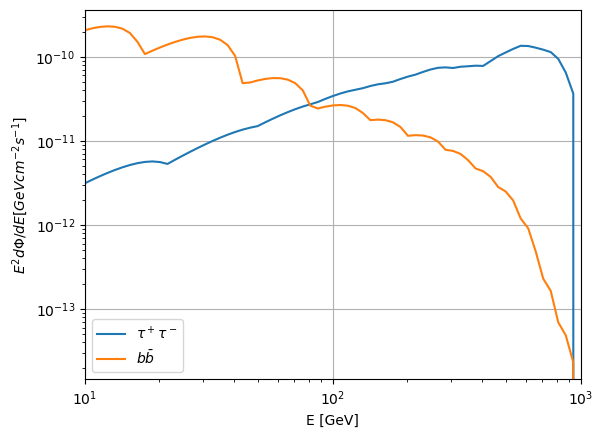

In [63]:
E=np.logspace(0,3,100)
plt.plot(E,E**2*dphide_channel(E,1000), label=r'$\tau^+\tau^-$')
plt.plot(E,E**2*dphide_channelb(E,1000), label=r'$b\bar{b}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.xlim([10,1000])
plt.xlabel(r'E [GeV]')
plt.ylabel(r'$E^2 d\Phi/dE [GeV cm^{-2} s^{-1}]$')
plt.savefig(r"\Users\Lexi\Documents\Uni\Bachelorthesis\Bilder\extrafluxtautau.pdf")
plt.savefig(r"\Users\Lexi\Documents\Uni\Bachelorthesis\Bilder\extrafluxtautau.png")